Реализовать с помощью Numpy класс MyMLP, моделирующий работу полносвязной нейронной сети.

Реализуемый класс должен

Поддерживать создание любого числа слоев с любым числом нейронов. Тип инициализации весов не регламентируется. Обеспечивать выбор следующих функции активации в рамках каждого слоя: ReLU, sigmoid, linear. Поддерживать решение задачи классификации и регрессии (выбор соответствующего лосса, в том числе для задачи многоклассовой классификации). В процессе обучения использовать самостоятельно реализованный механизм обратного распространения (вывод формул в формате markdown) для применения градиентного и стохастического градиентного спусков (с выбором размера батча) Поддерживать использование l1, l2 и l1l2 регуляризаций.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification, make_regression
from sklearn.model_selection import train_test_split

np.random.seed(42)

In [2]:
import numpy as np
import matplotlib.pyplot as plt

class MyMLP:
    def __init__(
        self,
        layer_sizes: list,
        activations: list,
        task_type: str = "regression",
        l1: float = 0.0,
        l2: float = 0.0,
        l1l2: float = 0.0,
        random_state: int = None
    ):
        self._validate_config(layer_sizes, activations, l1, l2, l1l2, task_type)

        self.layer_sizes = layer_sizes
        self.activations = [a.lower() for a in activations]
        self.task_type = task_type
        self.l1 = l1
        self.l2 = l2
        self.l1l2 = l1l2

        if random_state is not None:
            np.random.seed(random_state)

        self.weights, self.biases = [], []
        for i in range(len(layer_sizes) - 1):
            limit = np.sqrt(6 / (layer_sizes[i] + layer_sizes[i + 1]))
            self.weights.append(np.random.uniform(-limit, limit, (layer_sizes[i + 1], layer_sizes[i])))
            self.biases.append(np.zeros((layer_sizes[i + 1], 1)))

    @staticmethod
    def _validate_config(layer_sizes, activations, l1, l2, l1l2, task_type):
        if len(layer_sizes) < 2:
            raise ValueError("At least input and output sizes required in layer_sizes")
        if len(activations) != len(layer_sizes) - 1:
            raise ValueError("Number of activations must match number of layers - 1")
        if any(reg < 0 for reg in [l1, l2, l1l2]):
            raise ValueError("Regularization terms must be non-negative")
        valid_activations = {"relu", "sigmoid", "linear", "softmax"}
        for act in activations:
            if act.lower() not in valid_activations:
                raise ValueError(f"Invalid activation: {act}")
        if task_type == "classification" and activations[-1] not in {"sigmoid", "softmax"}:
            raise ValueError("For classification, last activation must be 'sigmoid' or 'softmax'")

    @staticmethod
    def _activation(x, activation: str):
        if activation == "relu":
            return np.maximum(0, x)
        elif activation == "sigmoid":
            return 1 / (1 + np.exp(-x))
        elif activation == "linear":
            return x
        elif activation == "softmax":
            exps = np.exp(x - np.max(x, axis=0, keepdims=True))
            return exps / np.sum(exps, axis=0, keepdims=True)

    @staticmethod
    def _activation_derivative(x, activation: str):
        if activation == "relu":
            return (x > 0).astype(float)
        elif activation == "sigmoid":
            s = MyMLP._activation(x, "sigmoid")
            return s * (1 - s)
        elif activation == "linear":
            return np.ones_like(x)
        elif activation == "softmax":
            return 1

    def forward(self, x: np.ndarray) -> np.ndarray:
        if x.ndim != 2 or x.shape[1] != self.layer_sizes[0]:
            raise ValueError("Input must be of shape (batch_size, input_dim)")

        current = x.T
        self.cache = [{"pre": None, "post": current}]
        for w, b, act in zip(self.weights, self.biases, self.activations):
            z = np.dot(w, current) + b
            current = self._activation(z, act)
            self.cache.append({"pre": z, "post": current})
        return current.T

    def _compute_loss(self, y_true: np.ndarray, y_pred: np.ndarray) -> float:
        if y_true.shape != y_pred.shape:
            raise ValueError("Shapes of y_true and y_pred must match")

        if self.task_type == "classification":
            if self.activations[-1] == "softmax":
                loss = -np.mean(y_true * np.log(y_pred + 1e-15))
            else:
                loss = -np.mean(y_true * np.log(y_pred + 1e-15) + (1 - y_true) * np.log(1 - y_pred + 1e-15))
        else:
            loss = np.mean((y_true - y_pred) ** 2)

        reg_loss = sum(
            self.l1 * np.sum(np.abs(w)) +
            self.l2 * np.sum(w**2) +
            self.l1l2 * (np.sum(np.abs(w)) + np.sum(w**2))
            for w in self.weights
        )
        return loss + reg_loss

    def backward(self, x: np.ndarray, y_true: np.ndarray, lr: float):
        size = x.shape[0]
        y_pred = self.cache[-1]["post"].T
        d_output = (y_pred - y_true).T if self.task_type == "classification" else (2 * (y_pred - y_true) / size).T

        for i in reversed(range(len(self.weights))):
            d_w = np.dot(d_output, self.cache[i]["post"].T) / size
            d_b = np.sum(d_output, axis=1, keepdims=True) / size

            d_w += self.l1 * np.sign(self.weights[i]) + 2 * self.l2 * self.weights[i]
            d_w += self.l1l2 * (np.sign(self.weights[i]) + 2 * self.weights[i])

            self.weights[i] -= lr * d_w
            self.biases[i] -= lr * d_b

            if i > 0:
                d_act = np.dot(self.weights[i].T, d_output)
                d_output = d_act * self._activation_derivative(self.cache[i]["pre"], self.activations[i - 1])

    def predict(self, x: np.ndarray) -> np.ndarray:
        out = self.forward(x)
        if self.task_type == "classification":
            return (out > 0.5).astype(int) if self.activations[-1] == "sigmoid" else np.argmax(out, axis=1)
        return out

    def fit(
        self,
        x: np.ndarray,
        y: np.ndarray,
        epochs: int = 100,
        batch_size: int = 32,
        learning_rate: float = 0.01,
        verbose: bool = True,
        validation_data: tuple = None
    ):
        losses, val_losses = [], []

        for epoch in range(epochs):
            indices = np.random.permutation(len(x))
            x_shuffled, y_shuffled = x[indices], y[indices]
            epoch_loss = 0

            for start in range(0, len(x), batch_size):
                end = start + batch_size
                x_batch, y_batch = x_shuffled[start:end], y_shuffled[start:end]
                self.forward(x_batch)
                self.backward(x_batch, y_batch, learning_rate)
                y_pred = self.cache[-1]["post"].T
                epoch_loss += self._compute_loss(y_batch, y_pred)

            epoch_loss /= (len(x) // batch_size)
            losses.append(epoch_loss)

            if validation_data:
                val_pred = self.forward(validation_data[0])
                val_loss = self._compute_loss(validation_data[1], val_pred)
                val_losses.append(val_loss)
                if verbose and epoch % 10 == 0:
                    print(f"Epoch {epoch}, Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}")
            elif verbose and epoch % 10 == 0:
                print(f"Epoch {epoch}, Train Loss: {epoch_loss:.4f}")

        plt.figure(figsize=(10, 6))
        plt.plot(losses, label="Train Loss")
        if validation_data:
            plt.plot(val_losses, label="Validation Loss")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.title("Training Progress")
        plt.legend()
        plt.grid(True)
        plt.show()

        return self


=== Регрессия без регуляризации ===
Epoch 0, Train Loss: 4222.9249
Epoch 10, Train Loss: 69.9536
Epoch 20, Train Loss: 47.3458
Epoch 30, Train Loss: 24.7713
Epoch 40, Train Loss: 8.7875


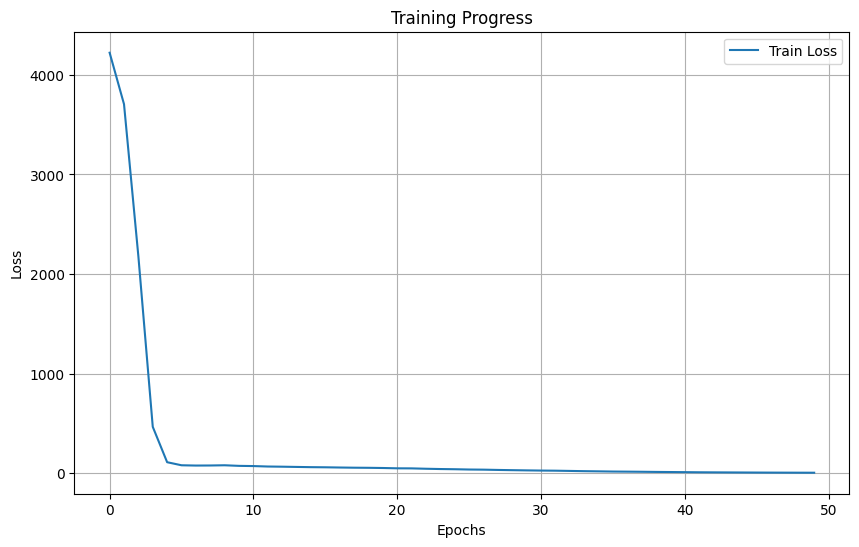

Train Loss (MSE): 2.9282570836483837


In [3]:
#Регрессия без регуляризации
print("=== Регрессия без регуляризации ===")
X_reg, y_reg = make_regression(n_samples=1000, n_features=5, noise=0.1, random_state=42)
y_reg = y_reg.reshape(-1, 1)

model_reg = MyMLP([5, 10, 1], ["relu", "linear"], task_type="regression")
model_reg.fit(X_reg, y_reg, epochs=50, batch_size=32, learning_rate=0.01)

train_pred = model_reg.forward(X_reg)
train_loss = model_reg._compute_loss(y_reg, train_pred)
print("Train Loss (MSE):", train_loss)




=== Регрессия с L2 регуляризацией ===
Epoch 0, Train Loss: 4297.5828
Epoch 10, Train Loss: 72.0906
Epoch 20, Train Loss: 57.3522
Epoch 30, Train Loss: 34.1671
Epoch 40, Train Loss: 14.8781


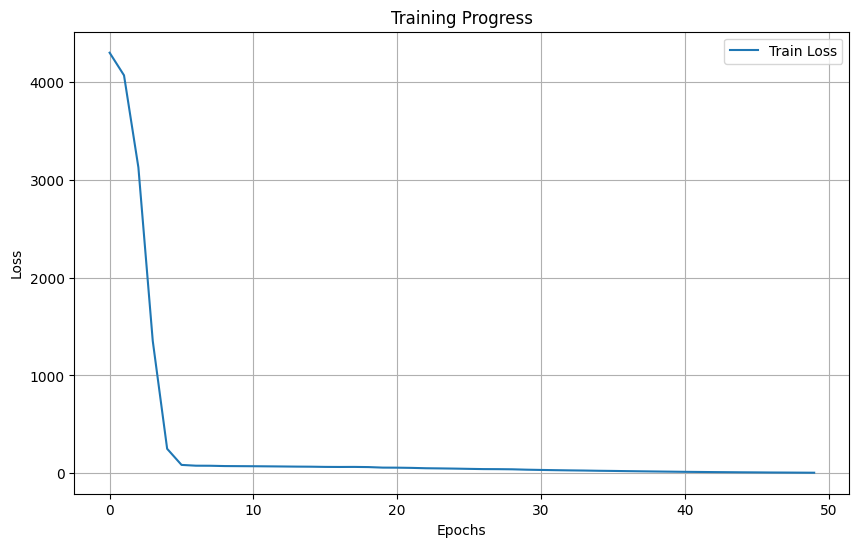

Train Loss с L2: 5.710811249591252


In [4]:
#Регрессия с L2 регуляризацией
print("\n=== Регрессия с L2 регуляризацией ===")
model_reg_l2 = MyMLP([5, 10, 1], ["relu", "linear"], task_type="regression", l2=0.001)
model_reg_l2.fit(X_reg, y_reg, epochs=50, batch_size=32, learning_rate=0.01)

train_pred_l2 = model_reg_l2.forward(X_reg)
train_loss_l2 = model_reg_l2._compute_loss(y_reg, train_pred_l2)
print("Train Loss с L2:", train_loss_l2)

In [5]:
print("Min/Max y_reg:", y_reg.min(), y_reg.max())
print("Std y_reg:", y_reg.std())

Min/Max y_reg: -223.0834366815274 173.1379589811568
Std y_reg: 64.68990906580557



=== Бинарная классификация ===
Epoch 0, Train Loss: 0.9646
Epoch 10, Train Loss: 0.5133
Epoch 20, Train Loss: 0.3982
Epoch 30, Train Loss: 0.3616
Epoch 40, Train Loss: 0.3590


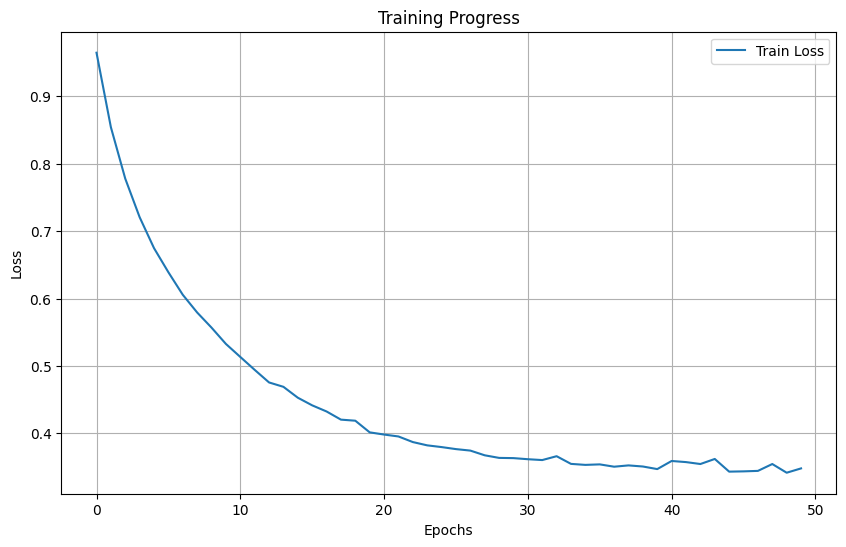

Train Loss (Binary Cross-Entropy): 0.3355118722469976
Predictions shape: (1000, 1)


In [6]:
#Бинарная классификация
print("\n=== Бинарная классификация ===")
X_clf, y_clf = make_classification(n_samples=1000, n_features=5, n_classes=2, random_state=42)
y_clf = y_clf.reshape(-1, 1)

model_clf = MyMLP([5, 10, 1], ["relu", "sigmoid"], task_type="classification")
model_clf.fit(X_clf, y_clf, epochs=50, batch_size=32, learning_rate=0.01)

train_pred_clf = model_clf.predict(X_clf)
train_loss_clf = model_clf._compute_loss(y_clf, model_clf.forward(X_clf))
print("Train Loss (Binary Cross-Entropy):", train_loss_clf)
print("Predictions shape:", train_pred_clf.shape)


=== Классификация с L1 регуляризацией ===
Epoch 0, Train Loss: 0.6927
Epoch 10, Train Loss: 0.4419
Epoch 20, Train Loss: 0.3853
Epoch 30, Train Loss: 0.3713
Epoch 40, Train Loss: 0.3621


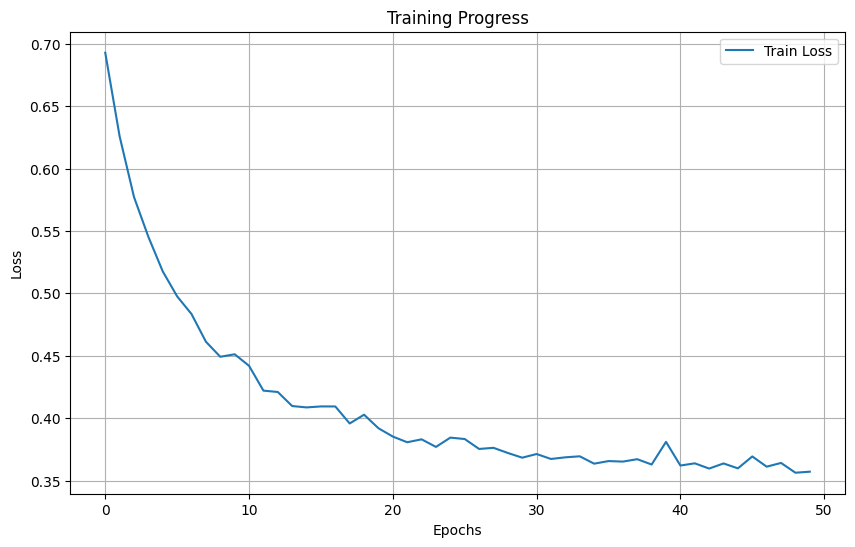

Train Loss с L1: 0.3513805605272828


In [7]:
#Классификация с L1 регуляризацией
print("\n=== Классификация с L1 регуляризацией ===")
model_clf_l1 = MyMLP([5, 10, 1], ["relu", "sigmoid"], task_type="classification", l1=0.001)
model_clf_l1.fit(X_clf, y_clf, epochs=50, batch_size=32, learning_rate=0.01)

train_pred_clf_l1 = model_clf_l1.predict(X_clf)
train_loss_clf_l1 = model_clf_l1._compute_loss(y_clf, model_clf_l1.forward(X_clf))
print("Train Loss с L1:", train_loss_clf_l1)

Epoch 0, Train Loss: 4156.3776
Epoch 10, Train Loss: 70.0225
Epoch 20, Train Loss: 54.4001
Epoch 30, Train Loss: 36.3279
Epoch 40, Train Loss: 16.6205


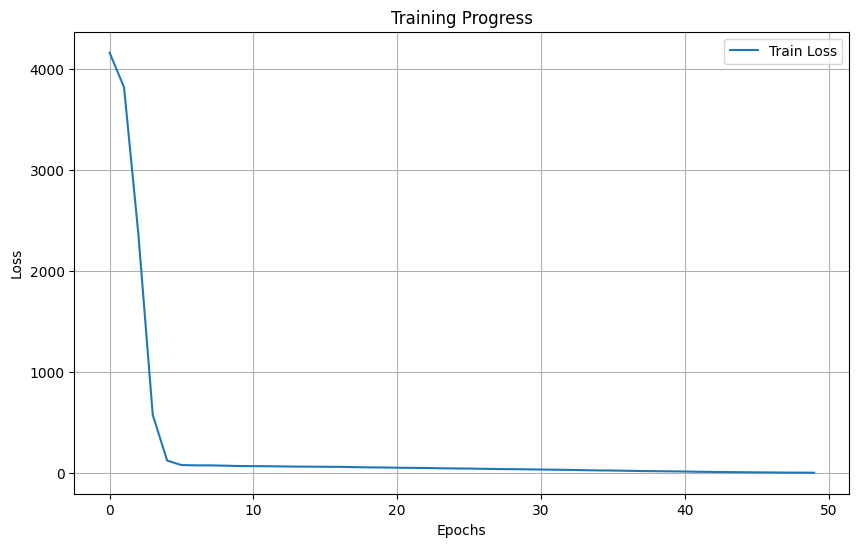

Train Loss с L1L2: 4.346300076810568


In [8]:
#Комбинированная регуляризация L1L2
model_combo = MyMLP([5, 10, 1], ["relu", "linear"], task_type="regression", l1l2=0.00005)
model_combo.fit(X_reg, y_reg, epochs=50, batch_size=32, learning_rate=0.01)

train_pred_combo = model_combo.forward(X_reg)
train_loss_combo = model_combo._compute_loss(y_reg, train_pred_combo)
print("Train Loss с L1L2:", train_loss_combo)